# Poisson equation with misspecified forcing model

In this experiment we assume that the observed data is generated by the process whose dynamics on the $(0,1)^2$ domain is given by
$$
-\Delta u = f,
$$
where 
$$
f(x, y) = 10 + 5(\sin(2\pi x) + \sin(2\pi y)),
$$
and $u(x, y) = 1$ when $x=1$ or $y=1$. We are implicitly imposing derivative-free Neumann boundary conditions at $x = 0$ or $y = 0$.

For the same of this experiment, we build a model without the knowledge of the true forcing function defined above and instead we assume a simpler forcing function
$$
f(x, y) = 10.
$$

We compute the prior solution using our assumed model before we observed the data, which are generated by the true process and measured with uncertainty (noise).

Subsequently, we combine the prior solution with the observations to estimate model parameters and compute the predictive posterior estimates. The parameters that are estimated are: misspecification magnitude ($\sigma_k$), misspecification lengthscale ($\ell_k$), and the scaling term ($\rho$).

For details of this please visit the [statFEM paper](https://arxiv.org/pdf/1905.06391.pdf).

In [212]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction, triplot
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem
import matplotlib.pyplot as plt

import os
from pathlib import Path

Make the mesh and necessary Firedrake objects to express the problem in the variational form. The mesh is 100 elements by 100 elements.

In [213]:
nx = 101

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

# Generating the true process

We compute the solution of the specified PDE given that we know the true forcing function.

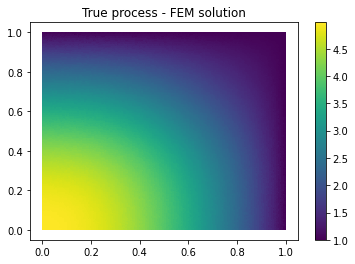

In [214]:
true_u = TrialFunction(V)
v = TestFunction(V)

true_f = Function(V)
x = SpatialCoordinate(mesh)
true_f.interpolate(10 + 5 * (sin(2 * pi * x[0]) + sin(2 * pi * x[1])))

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]

true_A = assemble((dot(grad(v), grad(true_u))) * dx, bcs=bc)
true_b = assemble(true_f * v * dx)

# Solve the PDE (using the true forcing)
true_u = Function(V)
solve(true_A, true_u, true_b)

plt.figure()
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              true_u.vector().dat.data)
plt.colorbar()
plt.title("True process - FEM solution")
plt.show()

# Making observations of the true process

We observe the solution $u$. We assume that measurements are noisy and the error follows the centred Gaussian with $\sigma_y$ standard deviation.

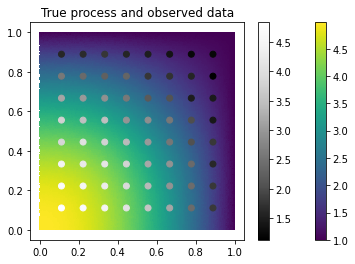

In [215]:
sigma_y = 1e-1 # the nugget (measurement noise)

datagrid = 8
ndata = datagrid**2 
x_data = np.zeros((ndata , 2))

count = 0
for i in range(datagrid):
    for j in range(datagrid):
        x_data[count, 0] = float(i + 1) / float(datagrid + 1)
        x_data[count, 1] = float(j + 1) / float(datagrid + 1)
        count += 1    
y = np.concatenate([true_u.at(x_data)]) + np.random.normal(scale=sigma_y, size=ndata)


plt.figure()
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              true_u.vector().dat.data)
plt.colorbar()
plt.scatter(x_data[:, 0], x_data[:, 1], c=y, cmap="Greys_r")
plt.colorbar()
plt.title("True process and observed data")
plt.show()

# The prior solution

Now, we assume that we do not know the forcing function. For the sake of this exercise, we assume constant forcing
$$
f(x, y) = 10.
$$

We will solve the PDE with this forcing and impose the boundary conditions as before.

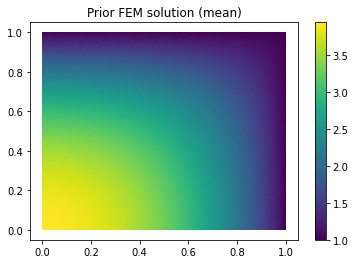

In [216]:
u = TrialFunction(V)
v = TestFunction(V)

# specify the constant forcing
f = Function(V)
x = SpatialCoordinate(mesh)
f.interpolate(Constant(10))

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]

A = assemble((dot(grad(v), grad(u))) * dx, bcs=bc)
b = assemble(f * v * dx)
u = Function(V)

solve(A, u, b) # firedrake solve

plt.figure()
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              u.vector().dat.data)
plt.colorbar()
plt.title("Prior FEM solution (mean)")
plt.show()

# Updating the model after observing data

## Estimate the parameters

We estimate $\rho$, $\sigma_k$, and $\ell_k$. We assume that the measurement noise, $\sigma_y$, is known. For the uncertainty of the forcing function we assume that the uncertainty term added to the forcing function is a zero-mean Gaussian Process with the squared exponential covariance function. For the moment, we fix the parameters of the covariance function based on the prior knowledge of the smoothness and variance of the forcing term error (misspecification)

In [ ]:
log_sigma_f = np.log(1)
log_l_f = np.log(0.2)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=0.5e-1)
G.assemble()

obs_data = stat_fem.ObsData(x_data, y, sigma_y)
ls = stat_fem.estimate_params_MAP(A, b, G, obs_data)

In [ ]:
ρ, σ_k, ℓ_k = np.exp(ls.params)
print(f"MAP estimates of (ρ, σ_k, ℓ_k): ({ρ}, {σ_k}, {ℓ_k})")

## Posterior estimates

### Posterior mean of $u_h$ after a single observation of the solution

Below is the plot of the posterior mean of $u_h$ in the mesh space.

In [ ]:
muy = Function(V)
ls.solve_posterior(muy)

plt.figure()
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              muy.vector().dat.data)
plt.colorbar()
plt.show()

#### Absolute difference between the posterior mean of $u_h$ and the prior mean.

In [ ]:
plt.figure()
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.abs(muy.vector().dat.data - u.vector().dat.data))
plt.colorbar()
plt.show()

This is better illustrated by comparing the true solution to the posterior mean at points lying along the diagonal of the domain

In [ ]:
posterior_func_values = muy.vector().dat.data
prior_func_values = u.vector().dat.data
true_func_values = true_u.vector().dat.data
mesh_coords = mesh.coordinates.vector().dat.data

selected_coords = mesh_coords[mesh_coords[:, 0] == mesh_coords[:, 1]] 
selected_vals_posterior = posterior_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]
selected_vals_prior = prior_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]
selected_vals_true = true_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]

plt.figure()
plt.plot(selected_coords[:, 0], selected_vals_prior)
plt.plot(selected_coords[:, 0], selected_vals_posterior)
plt.plot(selected_coords[:, 0], selected_vals_true)
plt.legend(['$u_{prior}$', '$u_{posterior}$', '$u_{true}$'])
plt.show()

### Posterior solution at grid locations before and after taking measurements

Note that as we update the solution $u$ we keep the estimates of $\rho$, $\sigma_k$, $\ell_k$ fixed at their MAP estimates obtained above. Ideally, one would update those estimates in light of new data. The updates performed below follow the Bayesian procedure: the posterior estimate from the previously observed data becomes the prior estimate before another set of data is observed.

In [ ]:
ls.data = obs_data
prior_mu_d, prior_Cu_d = ls.solve_prior()
post_mu_d, post_Cu_d = ls.solve_posterior_covariance()

diagonal_nodes_selector = x_data[:, 0] == x_data[:, 1]
selected_coords = x_data[diagonal_nodes_selector]

plt.figure()

# True process
true_process = np.concatenate([true_u.at(selected_coords)])
plt.plot(selected_coords[:, 0], true_process)

# Prior solution
plt.plot(selected_coords[:, 0], prior_mu_d[diagonal_nodes_selector])

n_obs = 100
plot_snapshots = [1, 10, 100]
for i in range(n_obs):
    ls.mu = post_mu_d
    ls.Cu = post_Cu_d
    ls.data = stat_fem.ObsData(x_data,
                               np.concatenate([true_u.at(x_data)]) + np.random.normal(scale=sigma_y, size=ndata), 
                               sigma_y)

    post_mu_d, post_Cu_d = ls.solve_posterior_covariance()
    
    if (i + 1) in plot_snapshots:
        plt.plot(selected_coords[:, 0], post_mu_d[diagonal_nodes_selector])

plt.legend(['True process', 'Prior'] + [f'Posterior $u$ after {n_obs} obs' for n_obs in plot_snapshots])

plt.show()

#### Posterior predictive distribution

The plot above shows the posterior mean of $u$ after different number of observations has been made. 

To plot predictive distribution $p\left(y | u_{\mbox{posterior}}\right)$ we scale the mean and the covariance function to get
$$
\mathcal{N}\left(\rho \Phi \mu_{u | y}, \rho^2 \Phi C_{u | y} \Phi^{\top} + K_k + \sigma_y^2 I\right)
$$

For details of this, please refere to the [statFEM paper](https://arxiv.org/abs/1905.06391).

In [ ]:
ls.data = obs_data
prior_mu_d, prior_Cu_d = ls.solve_prior()
post_mu_d, post_Cu_d = ls.solve_posterior_covariance()

diagonal_nodes_selector = x_data[:, 0] == x_data[:, 1]
selected_coords = x_data[diagonal_nodes_selector]

# True process
true_process = np.concatenate([true_u.at(selected_coords)])

# Prior solution
plt.figure()
plt.plot(selected_coords[:, 0], true_process)
plt.fill_between(selected_coords[:, 0], true_process-0, true_process+0, alpha=0.2)

temp = np.exp(ls.params[0]) * prior_mu_d[diagonal_nodes_selector]
plt.plot(selected_coords[:, 0], temp)
error = prior_Cu_d[diagonal_nodes_selector, diagonal_nodes_selector]
plt.fill_between(selected_coords[:, 0], temp-np.sqrt(error), temp+np.sqrt(error), alpha=0.2)


n_obs = 100
plot_snapshots = [1, 10, 100]
for i in range(n_obs):
    ls.mu = post_mu_d
    ls.Cu = post_Cu_d
    ls.data = stat_fem.ObsData(x_data,
                               np.concatenate([true_u.at(x_data)]) + np.random.normal(scale=sigma_y, size=ndata), 
                               sigma_y)

    post_mu_d, post_Cu_d = ls.solve_posterior_covariance()
    
    if (i + 1) in plot_snapshots:
        predictive_mean = ρ * post_mu_d[x_data[:, 0] == x_data[:, 1]]
        plt.plot(selected_coords[:, 0], predictive_mean)
        predictive_error = (ρ**2) * post_Cu_d[diagonal_nodes_selector, diagonal_nodes_selector] + sigma_y**2 + σ_k**2
        plt.fill_between(selected_coords[:, 0], predictive_mean-2*np.sqrt(predictive_error), predictive_mean+2*np.sqrt(predictive_error), alpha=0.2)

plt.legend(['True u', 'Predictive prior'] + [f'Predictive posterior after {n_obs} obs' for n_obs in plot_snapshots])
plt.show()